It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

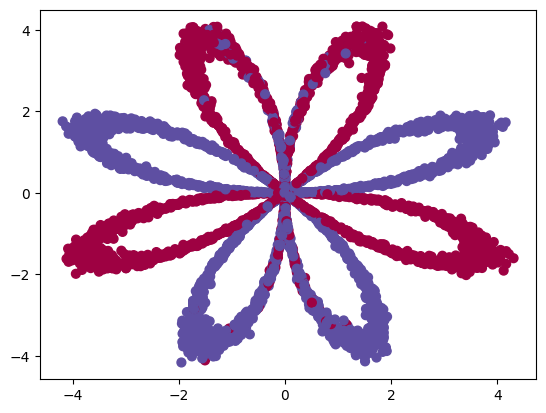

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [7]:
## X first example
X[0,:]

array([ 0.38060964, -2.30307871])

In [8]:
## Y firsts examples
y[:8]

array([0, 0, 0, 0, 1, 1, 0, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

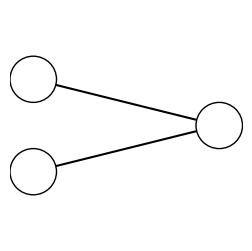

In [9]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [10]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

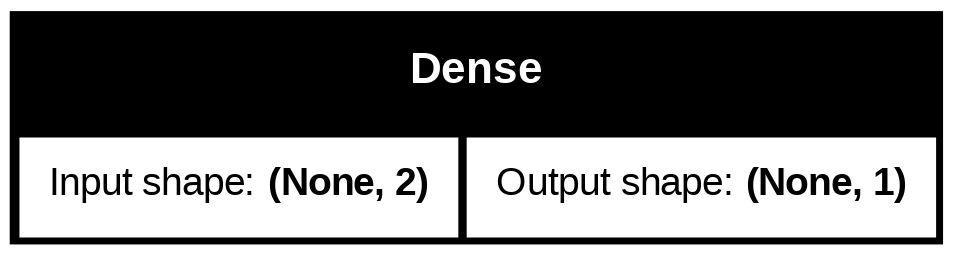

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [14]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3707 - loss: 1.4312 - val_accuracy: 0.3700 - val_loss: 1.3620
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3773 - loss: 1.3275 - val_accuracy: 0.3750 - val_loss: 1.2598
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3847 - loss: 1.2294 - val_accuracy: 0.3850 - val_loss: 1.1645
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3945 - loss: 1.1382 - val_accuracy: 0.3938 - val_loss: 1.0772
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4039 - loss: 1.0550 - val_accuracy: 0.4062 - val_loss: 0.9990
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4126 - loss: 0.9807 - val_accuracy: 0.4225 - val_loss: 0.9307
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4202 - loss: 0.9160 - val_accuracy: 0.4338 - val_loss: 0.8725
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4247 - loss: 0.8610 - val_accuracy: 0.

#### Making predictions

In [15]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.754397988319397
Test Accuracy: 0.4180000126361847


In [16]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(array([[0.5361086 ],
        [0.47663584],
        [0.4471426 ]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

1326/1326 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


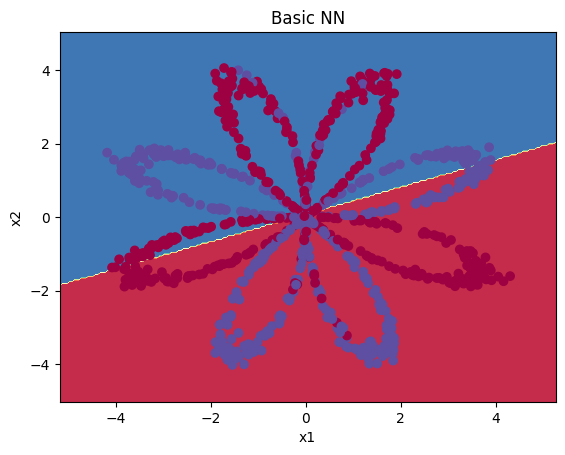

In [17]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

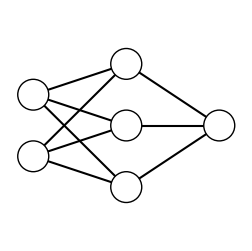

In [18]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [19]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

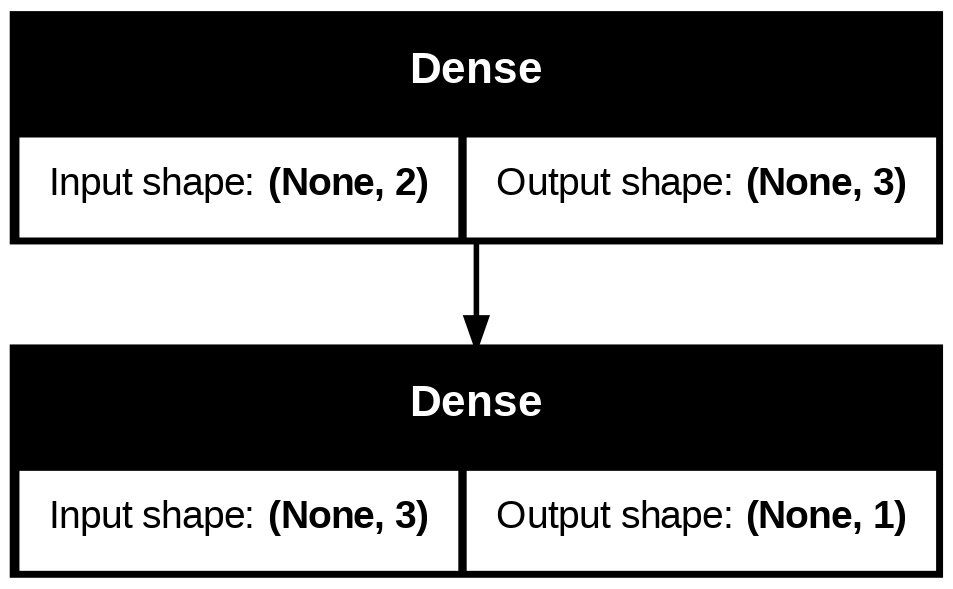

In [20]:
plot_model(model, show_shapes=True)

In [21]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4729 - loss: 0.7041 - val_accuracy: 0.3812 - val_loss: 0.6972
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4347 - loss: 0.6951 - val_accuracy: 0.5175 - val_loss: 0.6903
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5072 - loss: 0.6891 - val_accuracy: 0.4888 - val_loss: 0.6845
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5020 - loss: 0.6838 - val_accuracy: 0.4963 - val_loss: 0.6788
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5327 - loss: 0.6783 - val_accuracy: 0.5600 - val_loss: 0.6728
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6198 - loss: 0.6726 - val_accuracy: 0.6150 - val_loss: 0.6667
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6739 - loss: 0.6665 - val_accuracy: 0.6725 - val_loss: 0.6604
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6996 - loss: 0.6603 - val_accuracy: 0.

In [22]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5408873558044434
Test Accuracy: 0.847000002861023


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


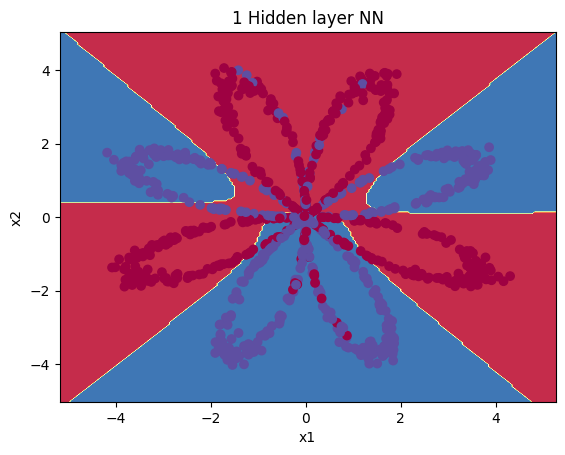

In [23]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [24]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5982 - loss: 0.8744 - val_accuracy: 0.5863 - val_loss: 0.8755
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6217 - loss: 0.7965 - val_accuracy: 0.6187 - val_loss: 0.8052
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6662 - loss: 0.7430 - val_accuracy: 0.6637 - val_loss: 0.7488
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7008 - loss: 0.7016 - val_accuracy: 0.6413 - val_loss: 0.7069
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6499 - loss: 0.6747 - val_accuracy: 0.5800 - val_loss: 0.6828
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5771 - loss: 0.6623 - val_accuracy: 0.5213 - val_loss: 0.6724
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5318 - loss: 0.6586 - val_accuracy: 0.4825 - val_loss: 0.6686
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5005 - loss: 0.6579 - val_accuracy: 0.

Test Loss: 0.6600891351699829
Test Accuracy: 0.4860000014305115
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


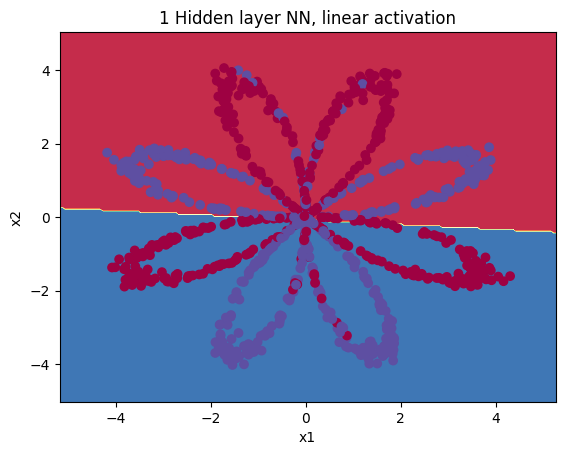

In [26]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

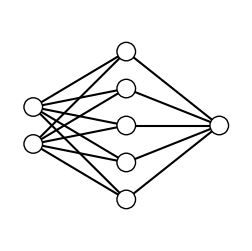

In [27]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [28]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4920 - loss: 0.6959 - val_accuracy: 0.5888 - val_loss: 0.6821
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6092 - loss: 0.6776 - val_accuracy: 0.5300 - val_loss: 0.6719
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5151 - loss: 0.6676 - val_accuracy: 0.4875 - val_loss: 0.6656
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4949 - loss: 0.6611 - val_accuracy: 0.4762 - val_loss: 0.6610
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4894 - loss: 0.6561 - val_accuracy: 0.4750 - val_loss: 0.6572
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4885 - loss: 0.6520 - val_accuracy: 0.4750 - val_loss: 0.6539
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4851 - loss: 0.6482 - val_accuracy: 0.4712 - val_loss: 0.6507
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4848 - loss: 0.6446 - val_accuracy: 0.

Test Loss: 0.5521907210350037
Test Accuracy: 0.7379999756813049
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


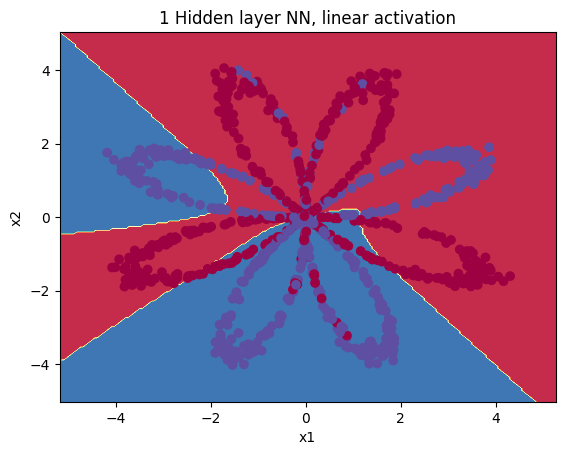

In [30]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

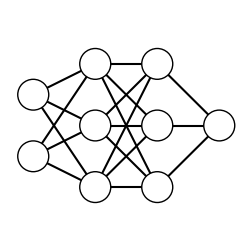

In [31]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [32]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4884 - loss: 0.7427 - val_accuracy: 0.4888 - val_loss: 0.7051
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4884 - loss: 0.7013 - val_accuracy: 0.4888 - val_loss: 0.6907
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4889 - loss: 0.6904 - val_accuracy: 0.5575 - val_loss: 0.6865
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6121 - loss: 0.6866 - val_accuracy: 0.6112 - val_loss: 0.6840
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6386 - loss: 0.6840 - val_accuracy: 0.6288 - val_loss: 0.6813
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6416 - loss: 0.6812 - val_accuracy: 0.6313 - val_loss: 0.6779
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6380 - loss: 0.6775 - val_accuracy: 0.6338 - val_loss: 0.6735
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.6729 - val_accuracy: 0.

Test Loss: 0.582026481628418
Test Accuracy: 0.6460000276565552
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


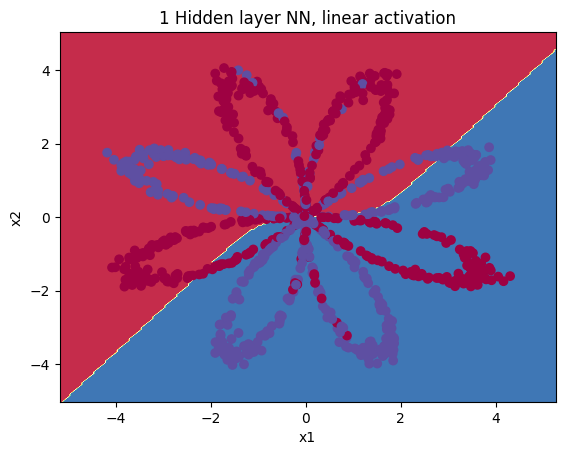

In [34]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [35]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6055 - loss: 0.8379 - val_accuracy: 0.6475 - val_loss: 0.7809
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6296 - loss: 0.7922 - val_accuracy: 0.6562 - val_loss: 0.7348
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6376 - loss: 0.7405 - val_accuracy: 0.6612 - val_loss: 0.6852
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6409 - loss: 0.6931 - val_accuracy: 0.6625 - val_loss: 0.6515
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6451 - loss: 0.6634 - val_accuracy: 0.6662 - val_loss: 0.6327
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6453 - loss: 0.6468 - val_accuracy: 0.6675 - val_loss: 0.6217
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6478 - loss: 0.6369 - val_accuracy: 0.6675 - val_loss: 0.6146
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6484 - loss: 0.6303 - val_accuracy: 0.

Test Loss: 0.5895828008651733
Test Accuracy: 0.6520000100135803
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


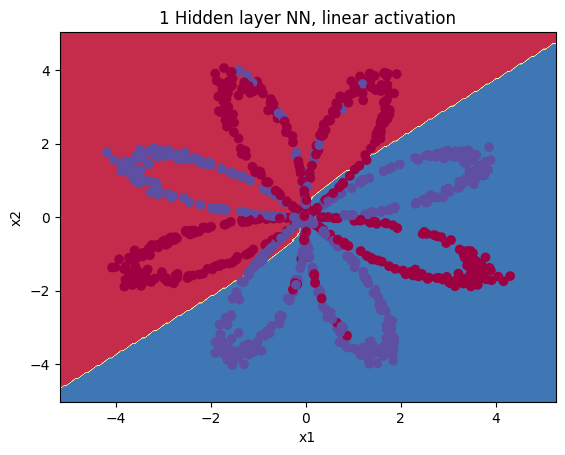

In [37]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [38]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

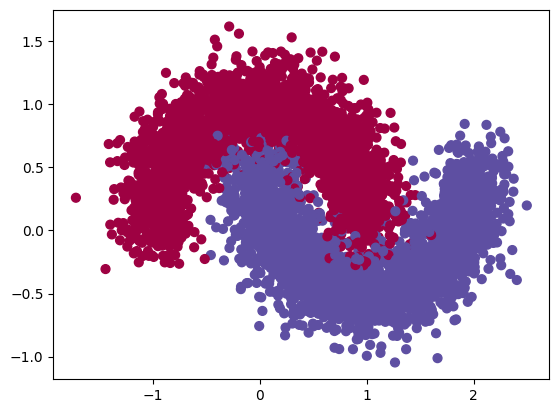

In [39]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [40]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [41]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(30, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(15, activation='tanh'))

model.add(layers.Dense(15, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6892 - loss: 0.5911 - val_accuracy: 0.8280 - val_loss: 0.3941
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8424 - loss: 0.3637 - val_accuracy: 0.8720 - val_loss: 0.3126
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8743 - loss: 0.2968 - val_accuracy: 0.8667 - val_loss: 0.2993
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8757 - loss: 0.2828 - val_accuracy: 0.8640 - val_loss: 0.2969
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8781 - loss: 0.2792 - val_accuracy: 0.8640 - val_loss: 0.2950
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8779 - loss: 0.2771 - val_accuracy: 0.8640 - val_loss: 0.2931
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8802 - loss: 0.2753 - val_accuracy: 0.8653 - val_loss: 0.2912
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.2736 - val_accuracy: 0.8653 - val_loss:

Test Loss: 0.06625440716743469
Test Accuracy: 0.9824000000953674
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


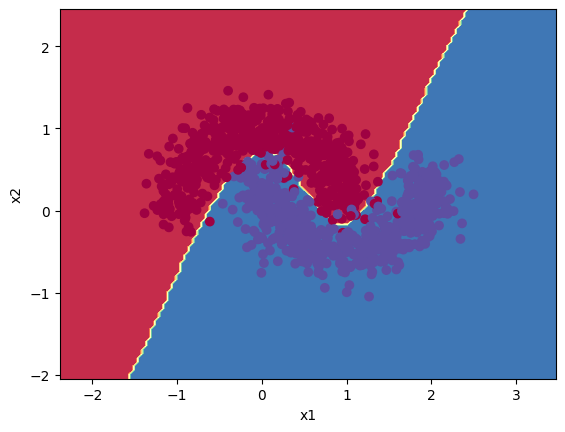

In [43]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Saving and Loading Keras Models

You can easily save your entire model (architecture, weights, and optimizer state) in a single call using either `.keras` or `.h5` formats.

- **`.keras`**: The default and recommended format from TensorFlow 2.12 onwards. It includes comprehensive model metadata and is future-proof.
- **`.h5`**: An older HDF5 format that is still widely used due to its simplicity and compatibility.


In [44]:
import datetime

# Save model with timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name_keras = f"keras_model_{current_time}.keras"
model_name_h5 = f"keras_model_{current_time}.h5"

# Save in .keras format (recommended for TensorFlow/Keras > 2.12)
model.save(model_name_keras)

# Alternatively, save in .h5 format
model.save(model_name_h5)

print(f"Models saved as: {model_name_keras} and {model_name_h5}")

Models saved as: keras_model_20250606-163102.keras and keras_model_20250606-163102.h5


In [45]:
# List files in current directory
!ls -l

total 124
-rw-r--r-- 1 root root 47516 Jun  6 16:31 keras_model_20250606-163102.h5
-rw-r--r-- 1 root root 40000 Jun  6 16:31 keras_model_20250606-163102.keras
-rw-r--r-- 1 root root 30749 Jun  6 16:29 model.png
drwxr-xr-x 1 root root  4096 Jun  4 21:29 sample_data


In [46]:
from tensorflow.keras.models import load_model

# Load your previously saved model
loaded_model = load_model(model_name_keras)  # or .h5

# Evaluate loaded model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded model accuracy: {accuracy*100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0634
Loaded model accuracy: 98.24%


### Question 4: Train 10 epochs, save the model, load it, and then train 10 more epochs

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers...(..., input_shape=(...,), activation=...))

## Second Layer, don't use input_shape
model...(...)

# output layer
model.add(layers.Dense(..., activation=...))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=..., validation_split=0.2, batch_size=64)

In [ ]:
# Save the model
model_name = ...
model.save(...

In [ ]:
# load the model
loaded_model = load_model(model_name_keras)


In [ ]:
# Train the model 10 more epochs
model.fit(X_train, y_train, epochs=..., validation_split=0.2, batch_size=64)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

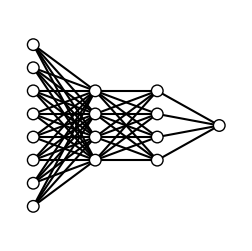

In [50]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [51]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

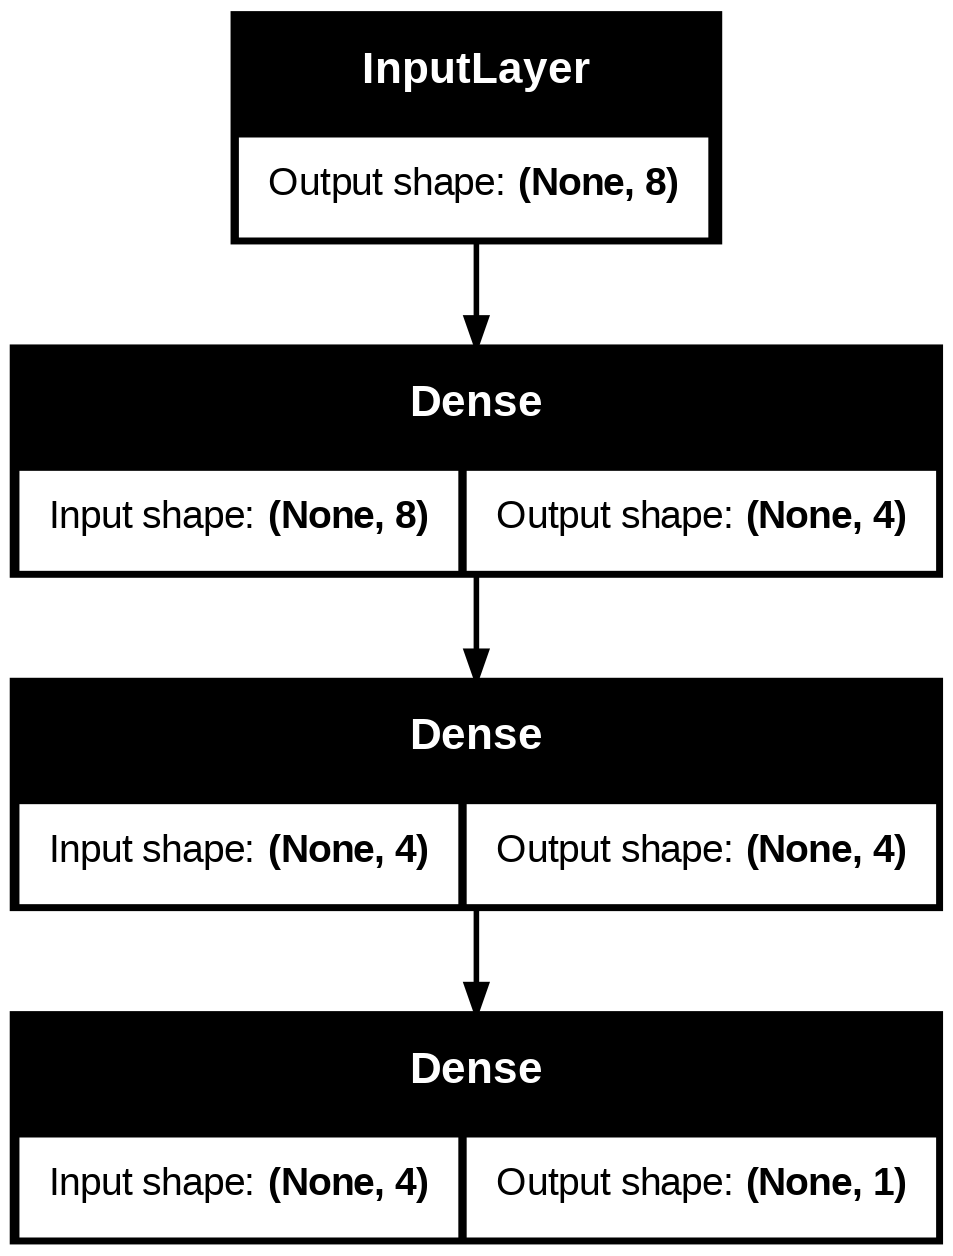

In [52]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [47]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

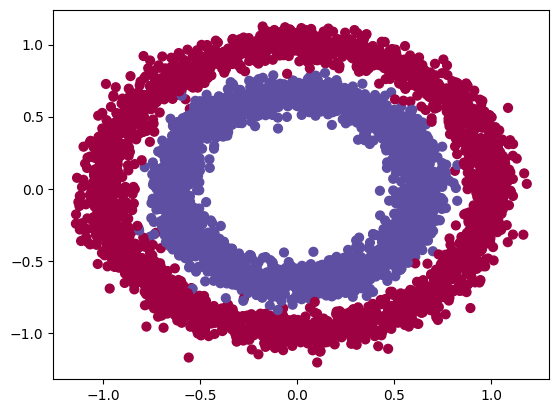

In [48]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [49]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [56]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)

## output layer
outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(l_2)


model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

In [57]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4793 - loss: 0.7052 - val_accuracy: 0.4947 - val_loss: 0.6980
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4712 - loss: 0.7003 - val_accuracy: 0.4920 - val_loss: 0.6951
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4805 - loss: 0.6969 - val_accuracy: 0.5133 - val_loss: 0.6925
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4977 - loss: 0.6940 - val_accuracy: 0.5253 - val_loss: 0.6899
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5113 - loss: 0.6911 - val_accuracy: 0.5373 - val_loss: 0.6871
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5404 - loss: 0.6880 - val_accuracy: 0.5720 - val_loss: 0.6828
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5885 - loss: 0.6818 - val_accuracy: 0.6200 - val_loss: 0.6750
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6218 - loss: 0.6731 - val_accuracy: 0.6680 - val_loss

Test Loss: 0.15022426843643188
Test Accuracy: 0.9879999756813049
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


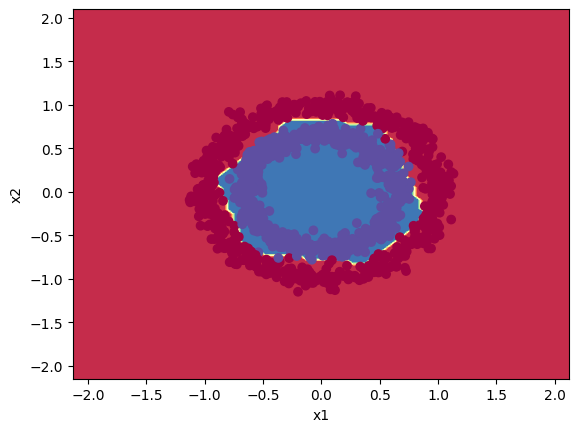

In [58]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Visualize decision boundary by epoch

In [59]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [60]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X, y = generate_spiral_dataset(n_points)

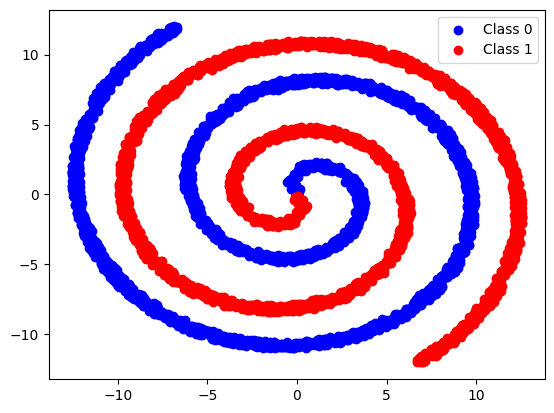

In [61]:
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [62]:
# Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 60
epoch_images = []

for epoch in range(n_epochs):
    model.fit(X_train, y_train, epochs=1, verbose=0)
    epoch_image = f'epoch_{epoch}.png'
    epoch_images.append(epoch_image)

    plot_save_decision_boundary(model, X_test, y_test, epoch, epoch_image)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━

In [64]:
from PIL import Image as Image_PIL

# Create the GIF
gif_filename = 'epoch_animation.gif'
images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images]

duration = 0.15
images[0].save(gif_filename,
            format='GIF',
            append_images=images[1:],
            save_all=True,
            duration=duration*1000,
            loop=0)

# Delete the individual epoch images
for epoch_image in epoch_images:
    os.remove(epoch_image)

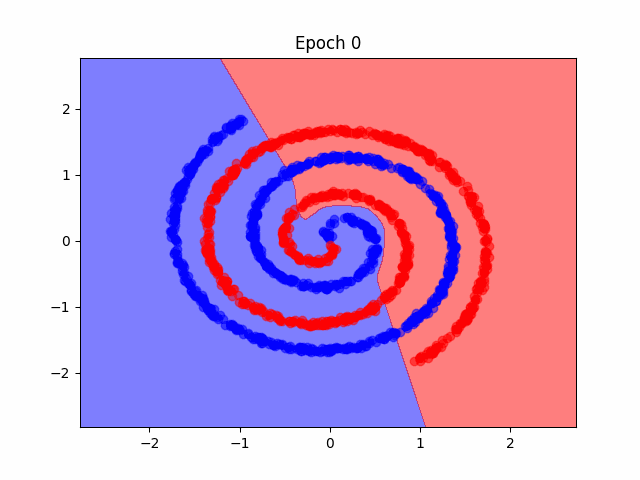

In [65]:
# Display the GIF
Image(filename=gif_filename)